# Unsupervised Bayesian Calibration or Bayesian Blind Source Separation

As discussed in the supervised part we have the following equation we want to model:
<br>
<br>
$Y = E\cdot \mathbf{1}_{1\times n_d} + diag(d)log(AS)$

where,

- $Y \in \mathbf{R}^{n_c \times n_d}$
- $E = [e_1,...,e_{n_c}]^\top$
- $d = d_1,...,d_{n_c}^\top$
- $A \in \mathbf{R}_{+}^{n_c\times n_s}$
- $S \in \mathbf{R}_{+}^{n_s\times n_d}$

Our model is:

$Y = E\cdot \mathbf{1}_{1\times n_d} + diag(d)log(AS) + \epsilon$, $\quad$ where $\epsilon$ ~ $Normal(0,\sigma)$

Unlike the the supervised case where we had access to both y and s at some number of time instants, now we only have access to y. We do not have any measurement for s at all. We still want to figure out what the A,E,D and S are in the equation. This is called the Blind Source Separation problem. This problem is ill-defined so the quality of our solution relies on the quality of our priors. 

### Priors for the model:

We will set up resonable prior on the distribution of the unknown parameters as follows:
- $S$ is the activity that we want to infer from the data. It should be non-negative and small values are encouraged as concentraion is not usually large (usually of the order milli molar). So,
$S$ ~ HlafNormal(\sigma_s = 1)

- $A$ is the selectivity coefficients of the senosrs and they have to be non negative numbers. We will choose it to be unifromly distributed between 0 and 1:
$A$ ~ $Uniform(0,1)$

- each $d_i$ is actually deterministic and takes the value $0.059/z_i$ where $z_i$ is the valance of the ith ion. But due to manufacturing fabrication processes it is not exactly this number but is close to it. So the prior for $d_i$ is: <br>
$d_i$ ~ $Normal(0.059/z_i, \sigma_{d_i})$ where $\sigma_{d_i}$ must be large enough to model the manufacturing variations.

- $e_i$ is also due to manifacturing variations and typically has a value in the interval [0.05, 0.35] so we can choose our prior as:<br>
$e_i$ ~ $Normal(0.2, \sigma_{e_i})$  where, $\sigma_{e_i}$ is chosen accordingly.

#### Likelihood

The likelihood for th mode is as follows: <br>

$Y = E\cdot \mathbf{1}_{1\times n_d} + diag(d)log(AS) + \epsilon$, $\quad$ where $\epsilon$ ~ $Normal(0,\sigma)$

Uisng the prior and the likelihood we can then fidn the posterior using Baye's theorem. This is the basic idea behind Bayesian ISE Calibration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import theano as tt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Generate the data
We will use the same parameters to generate the data. Note that in this case our model only gets to see the y values. So we will use the entire y values in our training. In other words num_obs = num_samples

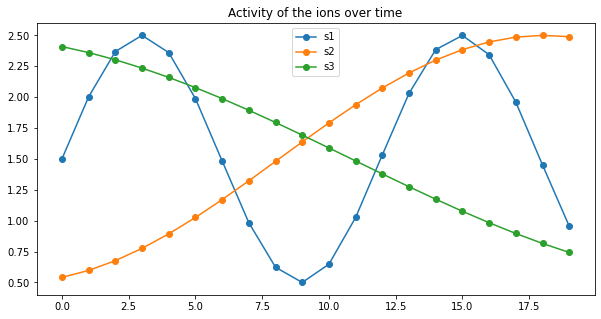

In [211]:
# only using 50 samples as the number of parameters to estimate grows with the 
# number of samples here. More parametres means slow sampling and other issues.

num_samples = 20    #num_obs = num_samples
num_electrodes = 3
num_sources = 3
AA = np.array([[1, 0.16, 0.40], [0.25, 1, 0.19], [0.40, 0.13, 1]])
d = [[0.059], [0.050], [0.055]]
e = [[0.095], [0.105], [0.110]]

s1 = (1.5 + np.sin(np.linspace(0,10, num_samples)))
s2 = (1.5 + np.sin(np.linspace(5,8, num_samples)))
s3 = (1.5 + np.sin(np.linspace(2,4, num_samples)))

S_comb = np.power([s1,s2,s3],1)
plt.figure(figsize=(10,5))
a=plt.plot(S_comb.T, marker='o')
plt.title('Activity of the ions over time')
plt.legend(['s1','s2','s3'])

E shape:  (3, 20)
D shape:  (3, 3)
S shape:  (3, 20)
Y shape:  (3, 20)


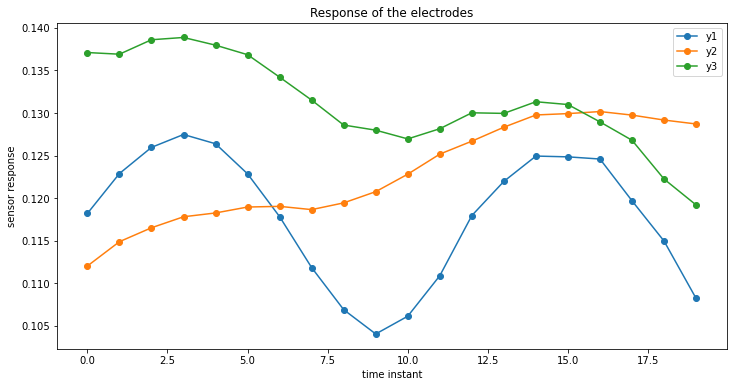

In [212]:
s_mean = 0
s_sigma = 0.5
noise_sigma = 0.0005
EE = np.matmul(e, np.ones((1, num_samples)))
DD = np.diag(np.array(d).T[0])
SS = S_comb
Y = EE + np.matmul(DD , np.log10(np.matmul(AA, SS)))
Y_obs = Y + np.random.normal(loc=0, scale=noise_sigma, size=Y.shape)

print('E shape: ', EE.shape)
print('D shape: ',DD.shape)
print('S shape: ',SS.shape)
print('Y shape: ', Y_obs.shape)
plt.figure(figsize=(12,6))
plt.plot(Y_obs.T, marker='o')
plt.xlabel('time instant')
plt.ylabel('sensor response')
plt.title("Response of the electrodes")
plt.legend(['y1','y2','y3'])


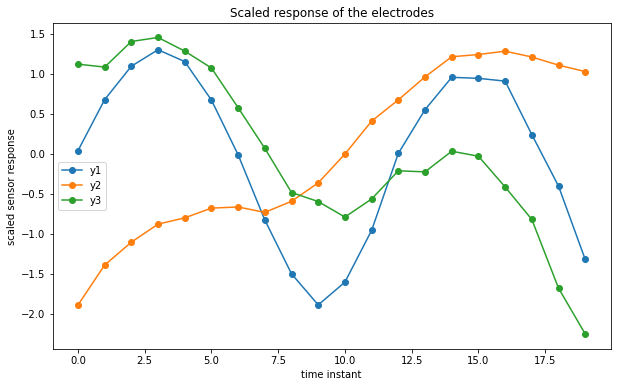

In [213]:
#scaling the data
scaler = StandardScaler() #RobustScaler() #MinMaxScaler()  
scaled_Y = scaler.fit_transform(Y_obs.T)
plt.figure(figsize=(10,6))
a = plt.plot(scaled_Y, marker='o')
plt.xlabel('time instant')
plt.ylabel('scaled sensor response')
plt.title("Scaled response of the electrodes")
plt.legend(['y1','y2','y3'])

In [214]:
scaler_mean = scaler.mean_.reshape(-1,1)
scaler_std = np.sqrt(scaler.var_).reshape(-1,1)
scaler_mean 
scaler_std 

array([[0.0073455 ],
       [0.00571608],
       [0.0053084 ]])

In [215]:
#scale = Y_obs.max(axis=1).reshape(-1,1)
#scaled_Y = Y_obs/scale
#scaled_Y.shape

Run the sampler and generate the posterior disribution of parameters.

In [217]:
samples = 2000
tune = 500
with pm.Model() as model:
  sigma_E = pm.HalfNormal('sigma_E', sigma=1)
  sigma_D = pm.HalfNormal('sigma_D', sigma=1)

  temp_E1 = pm.Normal('temp_E1', mu=0, sigma=1, shape=(1,num_electrodes))
  E1 =  pm.Deterministic('E1', 0.1 + 0.02*sigma_E*temp_E1)
  E = pm.Deterministic('E', pm.math.dot(E1.T, np.ones((1,num_samples))))
  
  diag = tt.shared(np.diag(np.ones(num_electrodes)))
  temp_D1 = pm.HalfNormal('temp_D1', sigma=1, shape=(1,num_electrodes))
  m = pm.math.dot(temp_D1.T, np.ones((1,num_electrodes)))
  D1 = diag*m
  D = pm.Deterministic('D', 0.045*diag + 0.01*sigma_D*D1)
 
  temp_A = pm.Uniform('temp_A', lower=0, upper=1, shape=(num_electrodes,num_sources))
  a1 = np.ones((num_electrodes,num_sources))
  np.fill_diagonal(a1, 0)
  a2 = np.zeros((num_electrodes,num_sources))
  np.fill_diagonal(a2, 1)
  diag1 = tt.shared(a1)
  diag2 = tt.shared(a2)
  temp_A1 = pm.Deterministic('temp_A1', temp_A*a1)
  A = pm.Deterministic('A', temp_A1 + a2)

  S = pm.HalfNormal('S', sigma=1, shape=(num_sources,num_samples))

  sigma_temp= pm.HalfNormal('sigma_temp', sigma=1)
  sigma_noise = pm.Deterministic('sigma_noise', 0.001*sigma_temp/scaler_std)

  #y_mean = E + pm.math.dot(D, np.log10(pm.math.dot(A, S))) 
  y_mean = (E + pm.math.dot(D , np.log10(pm.math.dot(A, S))) -scaler_mean)/scaler_std
  obs = pm.Normal('obs', mu=y_mean, sigma=sigma_noise, observed=scaled_Y.T)

  #obs = pm.StudentT('obs', nu=2, mu=y_mean, sigma=sigma, observed=scaled_Y.T)
  #start = pm.find_MAP()
  prior_checks = pm.sample_prior_predictive(samples=100)
  #trace0 = pm.sample(samples, tune=tune, chains=2, cores=1, target_accept=0.95)

Text(0.5, 1.0, 'Prior check for the obervations')

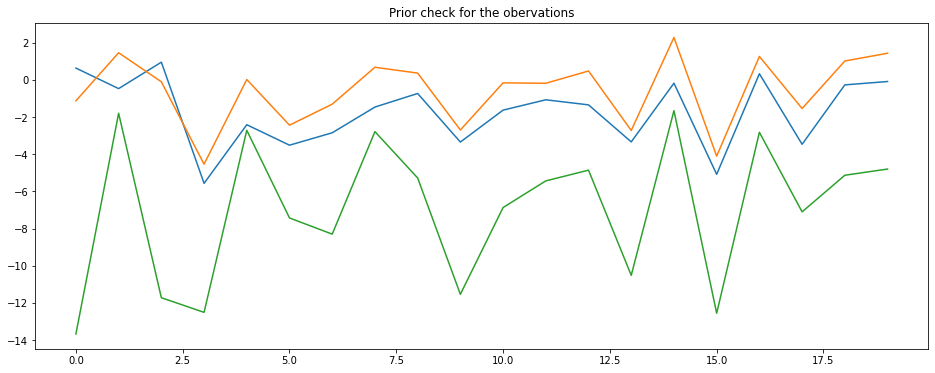

In [218]:
plt.figure(figsize=(16,6))
plt.plot(prior_checks['obs'][10].T)
plt.title('Prior check for the obervations')

The prior for observation y_obs looks good. It lies roughly within the bounds we would expect if we compare it to the scaled generated data.

In [219]:
plt.figure(figsize=(16,6))
prior_checks['A'][0]

array([[1.        , 0.58018268, 0.62630561],
       [0.81902655, 1.        , 0.67723933],
       [0.50641061, 0.97915908, 1.        ]])

<Figure size 1152x432 with 0 Axes>

Prior for A also look good. 

Text(0.5, 1.0, 'Prior check for D')

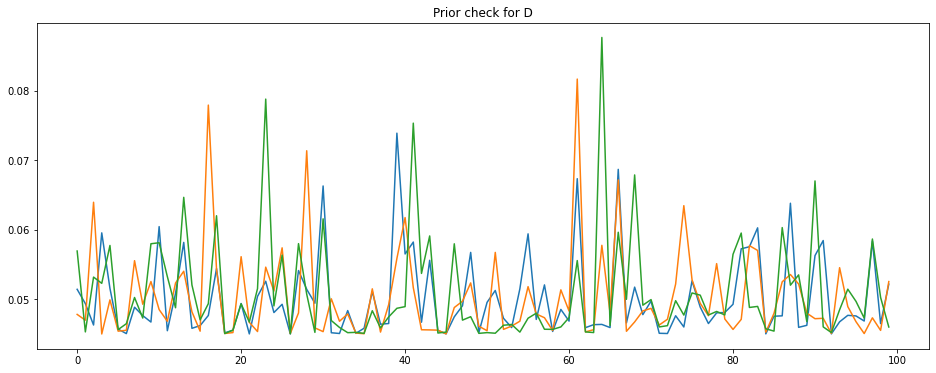

In [220]:
dlist = []
for i in range(len(prior_checks['D'])):
    dlist.append(np.diag(prior_checks['D'][i]))

dlist = np.array(dlist)
plt.figure(figsize=(16,6))
plt.plot(dlist)
plt.title('Prior check for D')

The ranges for the sampled prior D values are within the range we would expect.

Text(0.5, 1.0, 'Prior check for E')

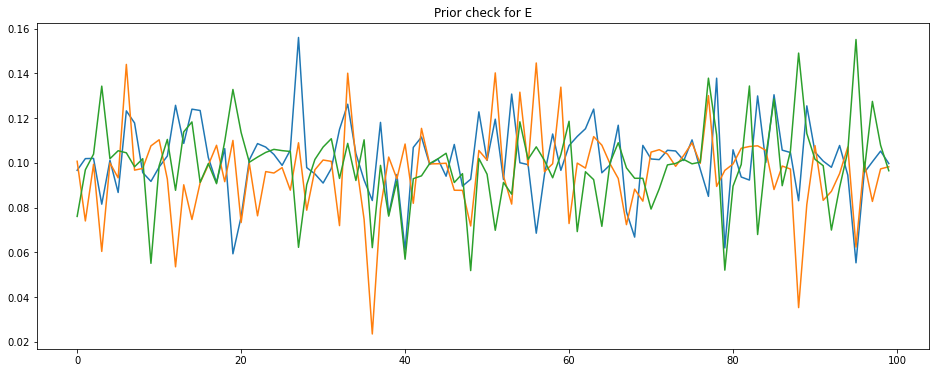

In [221]:
plt.figure(figsize=(16,6))
plt.plot(prior_checks['E'][:,:,0])
plt.title('Prior check for E')

The ranges for E also look resonable.

Text(0.5, 1.0, 'Prior check for S')

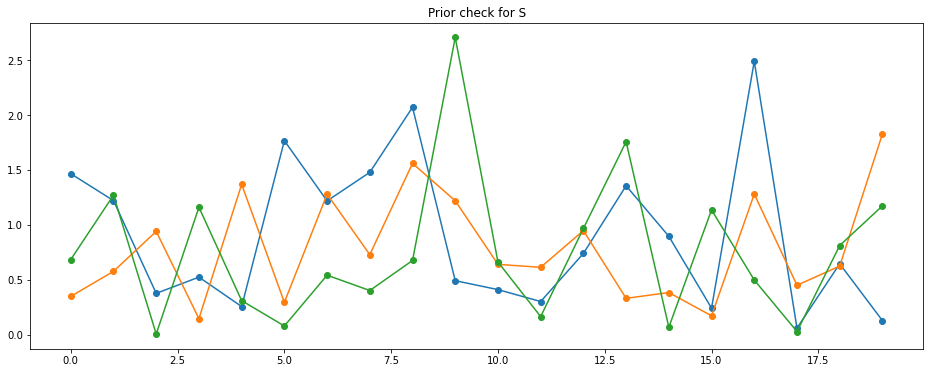

In [222]:
plt.figure(figsize=(16,6))
plt.plot(prior_checks['S'][3].T, marker='o')
plt.title('Prior check for S')

S is supposed to be between 0 and 1. From this prior check we can see that this is indeed the case.

### Let's look at the MAP(Maximum A-Postiriori) estimate and see what we get.

In [223]:
samples = 2000
tune = 500
with pm.Model() as model:
  sigma_E = pm.HalfNormal('sigma_E', sigma=1)
  sigma_D = pm.HalfNormal('sigma_D', sigma=1)

  temp_E1 = pm.Normal('temp_E1', mu=0, sigma=1, shape=(1,num_electrodes))
  E1 =  pm.Deterministic('E1', 0.1 + 0.02*sigma_E*temp_E1)
  E = pm.Deterministic('E', pm.math.dot(E1.T, np.ones((1,num_samples))))
  
  diag = tt.shared(np.diag(np.ones(num_electrodes)))
  temp_D1 = pm.HalfNormal('temp_D1', sigma=1, shape=(1,num_electrodes))
  m = pm.math.dot(temp_D1.T, np.ones((1,num_electrodes)))
  D1 = diag*m
  D = pm.Deterministic('D', 0.045*diag + 0.01*sigma_D*D1)
 
  temp_A = pm.Uniform('temp_A', lower=0, upper=1, shape=(num_electrodes,num_sources))
  a1 = np.ones((num_electrodes,num_sources))
  np.fill_diagonal(a1, 0)
  a2 = np.zeros((num_electrodes,num_sources))
  np.fill_diagonal(a2, 1)
  diag1 = tt.shared(a1)
  diag2 = tt.shared(a2)
  temp_A1 = pm.Deterministic('temp_A1', temp_A*a1)
  A = pm.Deterministic('A', temp_A1 + a2)

  S = pm.HalfNormal('S', sigma=1, shape=(num_sources,num_samples))

  sigma_temp= pm.HalfNormal('sigma_temp', sigma=1)
  sigma_noise = pm.Deterministic('sigma_noise', 0.001*sigma_temp/scaler_std)

  #y_mean = E + pm.math.dot(D, np.log10(pm.math.dot(A, S))) 
  y_mean = (E + pm.math.dot(D , np.log10(pm.math.dot(A, S)))-scaler_mean)/scaler_std
  obs = pm.Normal('obs', mu=y_mean, sigma=sigma_noise, observed=scaled_Y.T)

  #obs = pm.StudentT('obs', nu=2, mu=y_mean, sigma=sigma, observed=scaled_Y.T)
  MAP = pm.find_MAP()
  #prior_checks = pm.sample_prior_predictive(samples=100)
  #trace0 = pm.sample(samples, tune=tune, chains=2, cores=1, start=start, step=pm.Metropolis())
  #trace0 = pm.sample(samples, start=start, tune=tune, chains=2, cores=1, target_accept=0.95)

Text(0.5, 1.0, 'MAP estimate of S2')

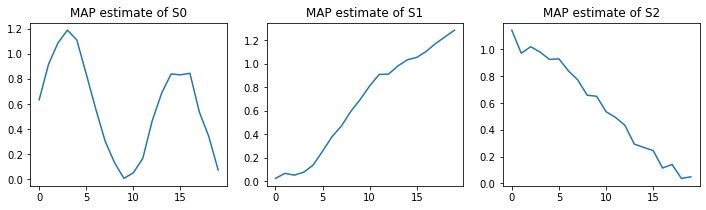

In [224]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].plot(MAP['S'][0])
ax[0].set_title('MAP estimate of S0')
ax[1].plot(MAP['S'][1])
ax[1].set_title('MAP estimate of S1')
ax[2].plot(MAP['S'][2])
ax[2].set_title('MAP estimate of S2')

The MAP estimates look very good. We would be fine using this as the final results. Although it worked in this case, usually, in high dimensional problems MAP does not work well.

### Let's now sample from the posterior and do a Bayesian estimation.

In [226]:
samples = 1500
tune = 1500
with pm.Model() as model:
  sigma_E = pm.HalfNormal('sigma_E', sigma=1)
  sigma_D = pm.HalfNormal('sigma_D', sigma=1)

  temp_E1 = pm.Normal('temp_E1', mu=0, sigma=1, shape=(1,num_electrodes))
  E1 =  pm.Deterministic('E1', 0.1 + 0.01*sigma_E*temp_E1)
  E = pm.Deterministic('E', pm.math.dot(E1.T, np.ones((1,num_samples))))
  
  diag = tt.shared(np.diag(np.ones(num_electrodes)))
  temp_D1 = pm.HalfNormal('temp_D1', sigma=1, shape=(1,num_electrodes))
  m = pm.math.dot(temp_D1.T, np.ones((1,num_electrodes)))
  D1 = diag*m
  D = pm.Deterministic('D', 0.05*diag + 0.01*sigma_D*D1)
 
  temp_A = pm.Uniform('temp_A', lower=0, upper=1, shape=(num_electrodes,num_sources))
  a1 = np.ones((num_electrodes,num_sources))
  np.fill_diagonal(a1, 0)
  a2 = np.zeros((num_electrodes,num_sources))
  np.fill_diagonal(a2, 1)
  diag1 = tt.shared(a1)
  diag2 = tt.shared(a2)
  temp_A1 = pm.Deterministic('temp_A1', temp_A*a1)
  A = pm.Deterministic('A', temp_A1 + a2)

  S = pm.HalfNormal('S', sigma=1, shape=(num_sources,num_samples))

  sigma_temp= pm.HalfNormal('sigma_temp', sigma=1)
  sigma_noise = pm.Deterministic('sigma_noise', 0.001*sigma_temp/scaler_std)

  #y_mean = E + pm.math.dot(D, np.log10(pm.math.dot(A, S))) 
  y_mean = (E + pm.math.dot(D , np.log10(pm.math.dot(A, S)))-scaler_mean)/scaler_std
  obs = pm.Normal('obs', mu=y_mean, sigma=sigma_noise, observed=scaled_Y.T)
  #obs = pm.StudentT('obs', nu=2, mu=y_mean, sigma=sigma, observed=scaled_Y.T)
  
  #step = pm.NUTS(max_treedepth=12, target_accept=0.95)
  trace0 = pm.sample(samples, tune=tune, chains=2, cores=1, target_accept=0.95)

C:\Users\16177\AppData\Local\Temp/ipykernel_27596/4214942692.py:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace0 = pm.sample(samples, tune=tune, chains=2, cores=1, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_temp, S, temp_A, temp_D1, temp_E1, sigma_D, sigma_E]


Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 1430 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


There are many things to note about this sampling run. There are many divergences. These are things to worry about as they tell us that our resuts might be biased. I haven't figured out a way to completely get rid of all divergences for this problem without causing poor sampling. I have tried reparameterization and incerasing target_accept but it we still have divergences. It could be a numerical issue and realted to the way the sampler is implemented. Secondly, the sampling took very long. This is becasue we have many more parameters this time. The entire S matrix is our parameter that we are interested in.

Let's look at the trace

C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaco

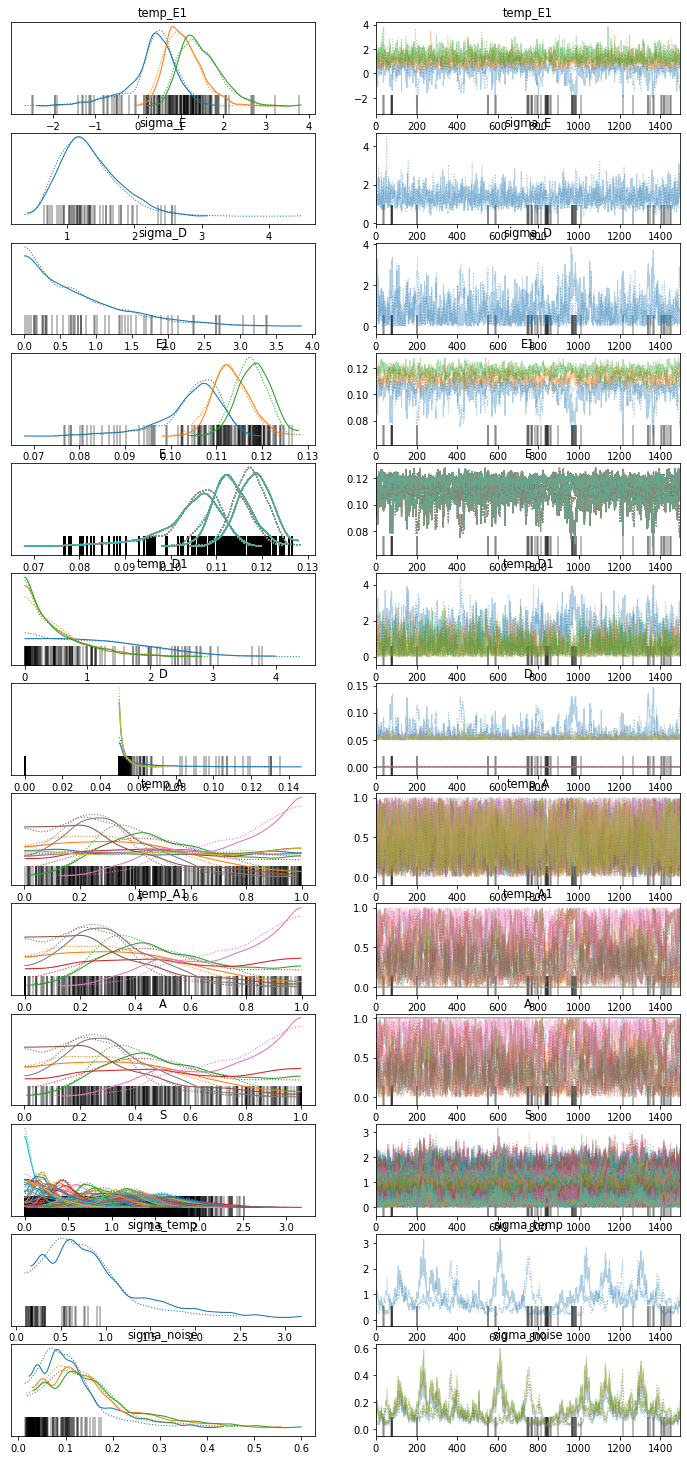

In [227]:
with pm.Model():
    pm.plot_trace(trace0)

The trace doesn't look too bad. Yes there are regions where the random walk is not very 'random' and there are many divergences. But overall, the distribution of the parameters looks ok. We have the true results, so we can see how good this trace actually is.

In [228]:
# get the samples from the posterior
with model:
  post_pred = pm.sample_posterior_predictive(trace0, var_names=['A','E','D','S','obs'])

In [229]:
S_hat = post_pred['S']
D_hat = post_pred['D']
A_hat = post_pred['A']
E_hat = post_pred['E']

In [230]:
S_hat.shape

(3000, 3, 20)

Text(0.5, 1.0, 'S2 predicted')

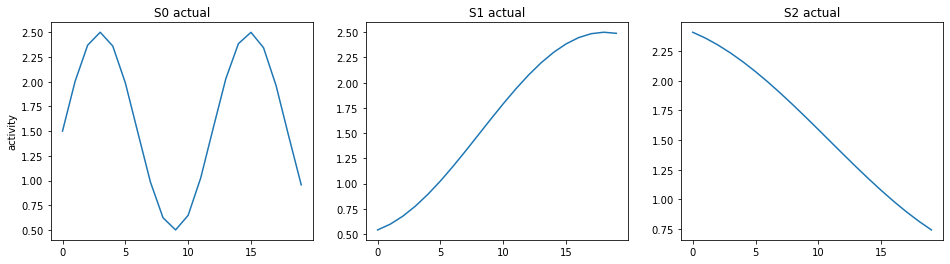

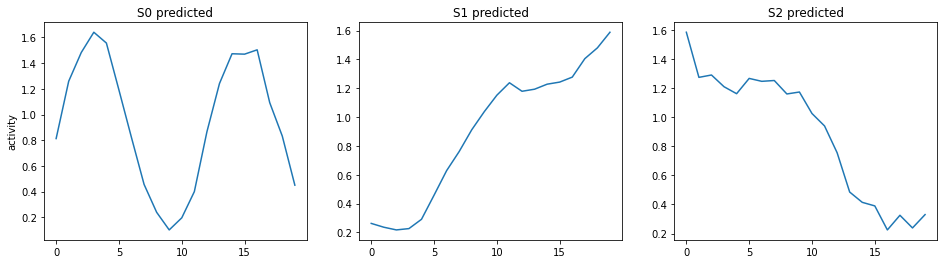

In [231]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(SS[0])
ax[1].plot(SS[1])
ax[2].plot(SS[2])
ax[0].set_title('S0 actual')
ax[1].set_title('S1 actual')
ax[2].set_title('S2 actual')
ax[0].set_ylabel('activity')

fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(S_hat.mean(axis=0)[0])
ax[1].plot(S_hat.mean(axis=0)[1])
ax[2].plot(S_hat.mean(axis=0)[2])
ax[0].set_ylabel('activity')
ax[0].set_title('S0 predicted')
ax[1].set_title('S1 predicted')
ax[2].set_title('S2 predicted')

Since this is a blind seperation method, we can only estimate the activity upto a scale and and intercept. That is we can only estimate S up to aS+b where a and b are another parameters we need to find. We can do this using simple linear regression which we will do next.

In [232]:
A_hat.mean(axis=0)

array([[1.        , 0.35966185, 0.5003721 ],
       [0.50373825, 1.        , 0.2704852 ],
       [0.74221874, 0.2903394 , 1.        ]])

In [233]:
AA

array([[1.  , 0.16, 0.4 ],
       [0.25, 1.  , 0.19],
       [0.4 , 0.13, 1.  ]])

In [234]:
D_hat.mean(axis=0)

array([[0.06115347, 0.        , 0.        ],
       [0.        , 0.05287637, 0.        ],
       [0.        , 0.        , 0.05260179]])

In [235]:
DD

array([[0.059, 0.   , 0.   ],
       [0.   , 0.05 , 0.   ],
       [0.   , 0.   , 0.055]])

In [236]:
print(E_hat.mean(axis=0)[0][0])
print(E_hat.mean(axis=0)[1][0])
print(E_hat.mean(axis=0)[2][0])
print(EE[0][0])
print(EE[1][0])
print(EE[2][0])

0.10435534123778617
0.11297820585274058
0.11788792265668958
0.095
0.105
0.11


Performing linear regression to get the scale and intercept parameter and then fitting to the actual data.

Text(0, 0.5, 'activity')

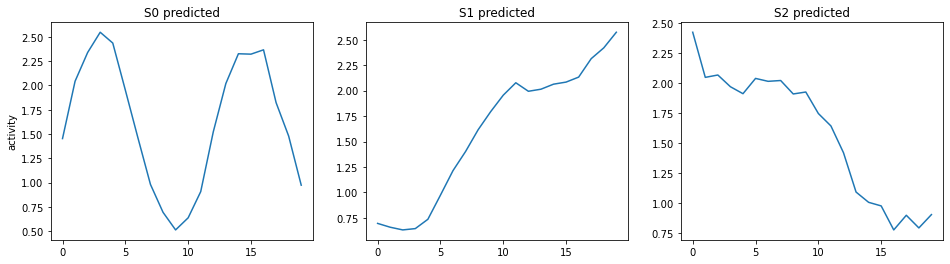

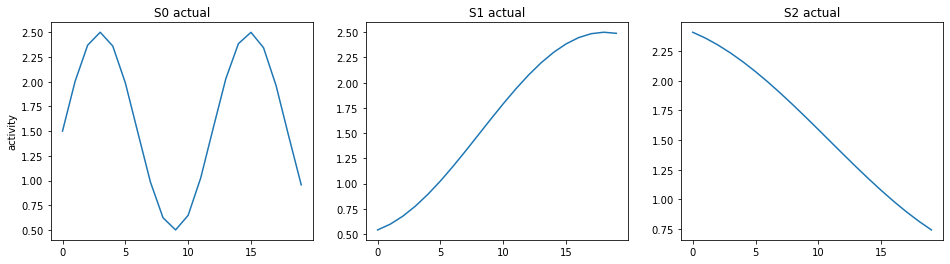

In [237]:
sample_id = (np.linspace(0,num_samples-1, 5)).astype(int)
y1 = S_comb[0][sample_id].reshape(-1,1)
y2 = S_comb[1][sample_id].reshape(-1,1)
y3 = S_comb[2][sample_id].reshape(-1,1)
x1 = S_hat.mean(axis=0)[0][sample_id].reshape(-1,1)
x2 = S_hat.mean(axis=0)[1][sample_id].reshape(-1,1)
x3 = S_hat.mean(axis=0)[2][sample_id].reshape(-1,1)

from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(x1,y1)
model2 = LinearRegression()
model2.fit(x2,y2)
model3 = LinearRegression()
model3.fit(x3,y3)
SS0 = model1.predict(S_hat.mean(axis=0)[0].reshape(-1,1))
SS1 = model2.predict(S_hat.mean(axis=0)[1].reshape(-1,1))
SS2 = model3.predict(S_hat.mean(axis=0)[2].reshape(-1,1))

fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(SS0)
ax[1].plot(SS1)
ax[2].plot(SS2)
ax[0].set_ylabel('activity')
ax[0].set_title('S0 predicted')
ax[1].set_title('S1 predicted')
ax[2].set_title('S2 predicted')

fig, ax1 = plt.subplots(1,3, figsize=(16,4))
ax1[0].plot(SS[0])
ax1[1].plot(SS[1])
ax1[2].plot(SS[2])
ax1[0].set_title('S0 actual')
ax1[1].set_title('S1 actual')
ax1[2].set_title('S2 actual')
ax1[0].set_ylabel('activity')

The plots look good considering the fact that we estimated all of this only using the observations y. We were succesfully able to ge the two bumps of S0 and also the peaks of those bumps to a resonable accuracy. We were able to get the upward slope and dwonward slope of S1 and S2 repqectively. When getting measurements of S for training is expensive, this method can be resonably good results.

Print the SNR values for each of the ion's activity

In [238]:
SNR0 =  10*np.log10((np.mean(SS[0]**2))/(np.mean((SS0-SS[0])**2)))
SNR1 =  10*np.log10((np.mean(SS[1]**2))/(np.mean((SS1-SS[1])**2)))
SNR2 =  10*np.log10((np.mean(SS[2]**2))/(np.mean((SS2-SS[2])**2)))
print(SNR0, SNR1, SNR2)

5.662610926680072 5.4149726147539265 7.122723032218564


In [239]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>